In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
import glob

# Precinct Shapefile
---
## VEST's Documentation File

Election results from South Carolina State Election Commission (https://www.enr-scvotes.org/SC/92124/Web02-state.222648/#/)
Precinct shapefile primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. The Lando/Lansford precinct in Chester County was merged to match the 2018 election results.

Absentee, provisional, emergency, and failsafe results were reported countywide. These were distributed to precincts based on the precinct's share of the county vote for each candidate.

In Spartanburg County the precinct labels for Trinity Methodist, Trinity Presbyterian, and West View Elementary were swapped to match the voter registration file. The boundary between Trinity Presbyterian and West View Elementary was also adjusted to match the county precinct map and the voter registration file.

* G18GOVDSMI - James Smith (Democratic Party)
* G18GOVRMCM - Henry McMaster (Republican Party)
* G18GOVOWRI - Write-in Votes


* G18SOSDWHI - Melvin T. Whittenburg (Democratic Party)
* G18SOSRHAM - Mark Hammond (Republican Party)
* G18SOSOWRI - Write-in Votes


* G18TREDGLE - Rosalyn L. Glenn (Democratic Party)
* G18TREWGLE - Rosalyn Glenn (Working Familites Party)
* G18TRERLOF - Curtis Loftis (Republican Party)
* G18TREAWOR - Sarah Work (American Party)
* G18TREOWRI - Write-in Votes


* G18ATGDANA - Constance Anastopoulo (Democratic Party)
* G18ATGWANA - Constance Anastopoulo (Working Families Party)
* G18ATGRWIL - Alan Wilson (Republican Party)
* G18ATGOWRI - Write-in Votes


* G18COMRECK - Richard Eckstrom (Republican Party)
* G18COMOWRI - Write-in Votes


* G18SPIRMIT - Molly Mitchell Spearman (Republican Party)
* G18SPIOWRI - Write-in Votes


* G18AGRUNEL - Chris Nelums (United Citizens Party)
* G18AGRGEDM - David Edmond (Green Party)
* G18AGRRWEA - Hugh Weathers (Republican Party)
* G18AGROWRI - Write-in Votes

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/sc_2018/sc_2018.shp")

In [3]:
vest_shp.shape

(2247, 28)

In [4]:
vest_shp.head(1)

,STATEFP,COUNTYFP,VTDST,NAME,G18GOVDSMI,G18GOVRMCM,G18GOVOWRI,G18SOSDWHI,G18SOSRHAM,G18SOSOWRI,...,G18ATGOWRI,G18COMRECK,G18COMOWRI,G18SPIRMIT,G18SPIOWRI,G18AGRUNEL,G18AGRGEDM,G18AGRRWEA,G18AGROWRI,geometry
0,45,001,000001,Abbeville No. 1,279,538,0,249,562,0,...,0,637,8,592,1,45,75,588,4,"POLYGON Z ((-82.41472 34.20777 0.00000, -82.41..."


<AxesSubplot:>

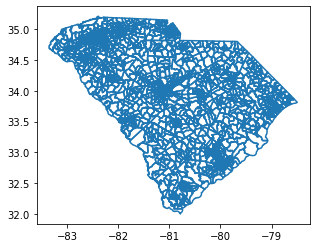

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'G18GOVDSMI', 'G18GOVRMCM',
       'G18GOVOWRI', 'G18SOSDWHI', 'G18SOSRHAM', 'G18SOSOWRI', 'G18TREDGLE',
       'G18TREWGLE', 'G18TRERLOF', 'G18TREAWOR', 'G18TREOWRI', 'G18ATGDANA',
       'G18ATGWANA', 'G18ATGRWIL', 'G18ATGOWRI', 'G18COMRECK', 'G18COMOWRI',
       'G18SPIRMIT', 'G18SPIOWRI', 'G18AGRUNEL', 'G18AGRGEDM', 'G18AGRRWEA',
       'G18AGROWRI', 'geometry'],
      dtype='object')

# Election Results

## Load Files
The SOS directed to this link for election results for the 2018 general: (https://www.enr-scvotes.org/SC/92124/Web02-state.222648/#/)

In [7]:
# Change setting to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# Select the folder with all the needed files
folder = os.listdir("./raw-from-source/Election_Results/3_Excel/")

# Create an empty list to add the all data
files = []
# Loop over all the files in the folder
for val in folder:
    # Set up a file path
    file_string = "./raw-from-source/Election_Results/3_Excel/" + val
    # Import file + specify sheets
    df = pd.concat(pd.read_excel(file_string, sheet_name = ['3','4','5','6','7','8','9']), axis = 1)
    # Flatten out the multi-level index
    df.columns = df.columns.droplevel()
    # Make the row with the candidates' names be the column names
    df.columns = df.iloc[0]
    # Rename the column with the precinct names as 'Precinct'
    df = df.rename(columns = {df.columns[0]:'Precinct'})
    # Add a number to each column
    df.columns = [f'{i}_{x}' for i, x in enumerate(df.columns, 1)]
    # Capitalize column names to match York County's
    df.columns = df.columns.str.upper()
    # Drop the first two rows (rows without data)
    df = df.iloc[2:]
    # Drop the rows with totals
    df = df[df['1_PRECINCT'] != 'Total:']
    # Add the county column
    df["COUNTY"] = val[:len(val) - 5]
    # Add the data to the list
    files.append(df)
#Create the final dataframe
sc_18 = pd.concat(files)

In [9]:
# Select the columns/data needed for validation
sc_18 = sc_18[['1_PRECINCT', '3_JAMES SMITH / MANDY POWERS NORRELL',
               '5_HENRY MCMASTER / PAMELA EVETTE','7_WRITE-IN', 
               '12_MELVIN T WHITTENBURG', '14_MARK HAMMOND',
               '16_WRITE-IN','21_ROSALYN L GLENN','23_ROSALYN GLENN','25_CURTIS LOFTIS', 
               '27_SARAH WORK','29_WRITE-IN','34_CONSTANCE ANASTOPOULO',
               '36_CONSTANCE ANASTOPOULO','38_ALAN WILSON','40_WRITE-IN',
               '45_RICHARD ECKSTROM','47_WRITE-IN','52_MOLLY MITCHELL SPEARMAN',
               '54_WRITE-IN','59_CHRIS NELUMS','61_DAVID EDMOND','63_HUGH WEATHERS',
               '65_WRITE-IN','COUNTY']]

In [10]:
# Rename the columns to match that of VEST's
sc_18 = sc_18.rename(columns = {'1_PRECINCT':'PRECINCT', 
                                '3_JAMES SMITH / MANDY POWERS NORRELL':'G18GOVDSMI',
                                '5_HENRY MCMASTER / PAMELA EVETTE':'G18GOVRMCM',
                                '7_WRITE-IN':'G18GOVOWRI',
                                '12_MELVIN T WHITTENBURG':'G18SOSDWHI',
                                '14_MARK HAMMOND':'G18SOSRHAM',
                                '16_WRITE-IN':'G18SOSOWRI',
                                '21_ROSALYN L GLENN':'G18TREDGLE', 
                                '23_ROSALYN GLENN':'G18TREWGLE', 
                                '25_CURTIS LOFTIS':'G18TRERLOF',
                                '27_SARAH WORK':'G18TREAWOR', 
                                '29_WRITE-IN':'G18TREOWRI',
                                '34_CONSTANCE ANASTOPOULO':'G18ATGDANA',
                                '36_CONSTANCE ANASTOPOULO':'G18ATGWANA', 
                                '38_ALAN WILSON':'G18ATGRWIL', 
                                '40_WRITE-IN':'G18ATGOWRI',
                                '45_RICHARD ECKSTROM':'G18COMRECK',
                                '47_WRITE-IN':'G18COMOWRI',
                                '52_MOLLY MITCHELL SPEARMAN':'G18SPIRMIT',
                                '54_WRITE-IN':'G18SPIOWRI',
                                '59_CHRIS NELUMS':'G18AGRUNEL', 
                                '61_DAVID EDMOND':'G18AGRGEDM', 
                                '63_HUGH WEATHERS':'G18AGRRWEA',
                                '65_WRITE-IN':'G18AGROWRI'})
# Reorder the columns to match that of VEST's
sc_18 = sc_18[['COUNTY','PRECINCT', 'G18GOVDSMI', 'G18GOVRMCM', 'G18GOVOWRI', 'G18SOSDWHI',
       'G18SOSRHAM', 'G18SOSOWRI', 'G18TREDGLE', 'G18TREWGLE', 'G18TRERLOF',
       'G18TREAWOR', 'G18TREOWRI', 'G18ATGDANA', 'G18ATGWANA', 'G18ATGRWIL',
       'G18ATGOWRI', 'G18COMRECK', 'G18COMOWRI', 'G18SPIRMIT', 'G18SPIOWRI',
       'G18AGRUNEL', 'G18AGRGEDM', 'G18AGRRWEA', 'G18AGROWRI']]

In [11]:
# Reset index
sc_18 = sc_18.reset_index(drop=True)

In [12]:
# Capitalize the first letter of the County names
sc_18['COUNTY'] = sc_18['COUNTY'].str.capitalize()
# Rename Mccormick County as McCormick County to match VEST 
sc_18 = sc_18.replace('Mccormick','McCormick')

In [13]:
# Change strings to integers (County and Precinct columns remain unchanged)
sc_18 = sc_18.apply(pd.to_numeric, errors='ignore')

## Validation

### Statewide Candidate Totals 

In [14]:
data_columns = ['G18GOVDSMI', 'G18GOVRMCM', 'G18GOVOWRI',
       'G18SOSDWHI', 'G18SOSRHAM', 'G18SOSOWRI', 'G18TREDGLE', 'G18TREWGLE',
       'G18TRERLOF', 'G18TREAWOR', 'G18TREOWRI', 'G18ATGDANA', 'G18ATGWANA',
       'G18ATGRWIL', 'G18ATGOWRI', 'G18COMRECK', 'G18COMOWRI', 'G18SPIRMIT',
       'G18SPIOWRI', 'G18AGRUNEL', 'G18AGRGEDM', 'G18AGRRWEA', 'G18AGROWRI']
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [15]:
statewide_totals_check(vest_shp,sc_18,data_columns)

***Statewide Totals Check***
G18GOVDSMI is equal 	VEST / RDH: 784182
G18GOVRMCM is equal 	VEST / RDH: 921342
G18GOVOWRI is equal 	VEST / RDH: 2045
G18SOSDWHI is equal 	VEST / RDH: 727952
G18SOSRHAM is equal 	VEST / RDH: 970576
G18SOSOWRI is equal 	VEST / RDH: 968
G18TREDGLE is equal 	VEST / RDH: 694200
G18TREWGLE is equal 	VEST / RDH: 28777
G18TRERLOF is equal 	VEST / RDH: 952233
G18TREAWOR is equal 	VEST / RDH: 25979
G18TREOWRI is equal 	VEST / RDH: 711
G18ATGDANA is equal 	VEST / RDH: 729694
G18ATGWANA is equal 	VEST / RDH: 35112
G18ATGRWIL is equal 	VEST / RDH: 938032
G18ATGOWRI is equal 	VEST / RDH: 996
G18COMRECK is equal 	VEST / RDH: 1136932
G18COMOWRI is equal 	VEST / RDH: 26028
G18SPIRMIT is equal 	VEST / RDH: 998057
G18SPIOWRI is equal 	VEST / RDH: 18866
G18AGRUNEL is equal 	VEST / RDH: 118671
G18AGRGEDM is equal 	VEST / RDH: 202238
G18AGRRWEA is equal 	VEST / RDH: 1015366
G18AGROWRI is equal 	VEST / RDH: 5025


### County Totals

#### Add in County FIPS Data

In [16]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="South Carolina"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
SC_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Use the dictionary to go from a county name to a county FIPS
sc_18["COUNTYFP"] = sc_18["COUNTY"].map(SC_fips_dict).fillna(sc_18["COUNTY"])

# Check the number of counties - looking for 46
print(len(sc_18["COUNTYFP"].unique()))

46


#### Check the Results

In [17]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [18]:
county_totals_check(vest_shp,sc_18,data_columns,"COUNTYFP", full_print=False)

***Countywide Totals Check***

G18GOVDSMI is equal across all counties
G18GOVRMCM is equal across all counties
G18GOVOWRI is equal across all counties
G18SOSDWHI is equal across all counties
G18SOSRHAM is equal across all counties
G18SOSOWRI is equal across all counties
G18TREDGLE is equal across all counties
G18TREWGLE is equal across all counties
G18TRERLOF is equal across all counties
G18TREAWOR is equal across all counties
G18TREOWRI is equal across all counties
G18ATGDANA is equal across all counties
G18ATGWANA is equal across all counties
G18ATGRWIL is equal across all counties
G18ATGOWRI is equal across all counties
G18COMRECK is equal across all counties
G18COMOWRI is equal across all counties
G18SPIRMIT is equal across all counties
G18SPIOWRI is equal across all counties
G18AGRUNEL is equal across all counties
G18AGRGEDM is equal across all counties
G18AGRRWEA is equal across all counties
G18AGROWRI is equal across all counties


### Precinct Totals

#### Allocate Absentee Votes

In [19]:
# Create a list with votes to allocate
to_allocate_list = ['Absentee','Absentee 1','Absentee 2','Absentee 3','Absentee 4','Absentee 5','Absentee - B',
'Emergency','Emergency 1','Emergency 2','Emergency 3','Emergency 4','Emergency 5','Emergency - B',
'Failsafe','Failsafe 1','Failsafe 2','Failsafe 3','Failsafe 4','Failsafe 5','Failsafe - B',
'Provisional','Provisional 1','Provisional 2','Provisional 3','Provisional 4','Provisional 5','Provisional - B',
'Failsafe Provisional','Failsafe Provisional 1','Failsafe provisonal 1','Failsafe/Provisional']

to_allocate = sc_18[sc_18["PRECINCT"].isin(to_allocate_list)]
to_add_to = sc_18[~sc_18["PRECINCT"].isin(to_allocate_list)]

In [20]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [ ]:
sc_18 = allocate_absentee(to_add_to,to_allocate,data_columns,'COUNTYFP')

#### Join Attempt 1

In [ ]:
# Capitalize precinct names in both files
vest_shp['NAME'] = vest_shp['NAME'].str.capitalize()
sc_18['PRECINCT'] = sc_18['PRECINCT'].str.capitalize()

In [ ]:
#Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp["NAME"]
#Check to make sure it is unique
# print(vest_shp["join_col"].value_counts(dropna=False))

#Create an election results join col
sc_18["join_col"] = sc_18["COUNTYFP"]+"-"+sc_18["PRECINCT"]
#Check to make sure it is unique
# print(sc_18["join_col"].value_counts(dropna=False))

In [ ]:
join_attempt_one = pd.merge(vest_shp,sc_18,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

In [ ]:
election_vest_id_changes_dict ={"001-Donald's": '001-Donalds', '005-Allendale #1': '005-Allendale no. 1', '005-Allendale #2': '005-Allendale no. 2', '005-Fairfax #1': '005-Fairfax no. 1', '005-Fairfax #2': '005-Fairfax no. 2', "007-Barker's creek-mcadams": "007-Barker's creek", '007-Fork no.1': '007-Fork no. 1', '007-Fork no.2': '007-Fork no. 2', "007-Neal's creek": '007-Neals creek', '007-North pointe': '007-North point', "007-Shirley's store": '007-Shirleys store', "007-Wright's school": '007-Wrights school', "007-Cox's creek": '007-Cox creek', '011-Barnwell 1': '011-Barnwell no. 1', '011-Barnwell 2': '011-Barnwell no. 2', '011-Barnwell 3': '011-Barnwell no. 3', '011-Barnwell 4': '011-Barnwell no. 4', '011-Blackville 1': '011-Blackville no. 1', '011-Blackville 2': '011-Blackville no. 2', '011-Williston 1': '011-Williston no. 1', '011-Williston 2': '011-Williston no. 2', '011-Williston 3': '011-Williston no. 3', '013-Saint helena 1a': '013-St. helena 1a', '013-Saint helena 1b': '013-St. helena 1b', '013-Saint helena 1c': '013-St. helena 1c', '013-Saint helena 2a': '013-St. helena 2a', '013-Saint helena 2b': '013-St. helena 2b', '013-Saint helena 2c': '013-St. helena 2c', '019-Lincolnville': '019-Licolnville', '021-Antioch and kings creek': "021-Antioch and king's creek", '021-Holly grove-buffalo': '021-Holly grove and buffalo', "021-Littlejohn's and sarratt's": "021-Little john and sarratt's", '021-Woods': "021-Wood's", '025-Mt. groghan': '025-Mt. croghan', '029-Canadys': "029-Canady's", '029-Wolf creek': '029-Wolfe creek', '037-Edgefield no.1': '037-Edgefield no. 1', '037-Edgefield no.2': '037-Edgefield no. 2', '037-Johnston no.1': '037-Johnston no. 1', '037-Johnston no.2': '037-Johnston no. 2', '037-Trenton no.1': '037-Trenton 1', '037-Merriweather no.1': '037-Merriweather no. 1', '037-Merriweather no.2': '037-Merriweather no. 2', '037-Trenton no.2': '037-Trenton 2', '039-Gladde3n grove': '039-Gladden grove', '039-Jenkinsville': '039-Jekinsville', '039-Woodard': '039-Woodward', '049-Hampton courthouse no.1': '049-Hampton cthse 1', '049-Hampton courthouse no.2': '049-Hampton cthse 2', "057-Gooch's cross roads": "057-Gooch's cross road", '061-Bishopville 1': '061-Bishopville no. 1', '061-Bishopville 2': '061-Bishopville no. 2', '061-Bishopville 4': '061-Bishopville no. 4', '061-South lynchburg': '061-S lynchburg', '061-Bishopville 3': '061-Bishopville no. 3', '063-Beulah  church': '063-Beulah church', "065-Clark's hill": '065-Clarks hill', '067-N west mullins': '067-Northwest mullins', '067-S west mullins': '067-Southwest mullins', '067-N east mullins': '067-Northeast mullins', '067-S east mullins': '067-Southeast mullins', '069-Red hill': '069-Redhill', '069-E bennettsville': '069-East bennettsville', '069-W bennettsville': '069-West bennettsville', '069-S bennettsville': '069-South bennettsville', '069-N bennettsville': '069-North bennettsville', '075-Orangeburg wd 1': '075-Orangeburg ward 1', '075-Orangeburg wd 2': '075-Orangeburg ward 2', '075-Orangeburg wd 3': '075-Orangeburg ward 3', '075-Orangeburg wd 4': '075-Orangeburg ward 4', '075-Orangeburg wd 5': '075-Orangeburg ward 5', '075-Orangeburg wd 6': '075-Orangeburg ward 6', '075-Ornageburg wd 7': '075-Orangeburg ward 7', '075-Orangeburg wd 8': '075-Orangeburg ward 8', '075-Orangeburg wd 9': '075-Orangeburg ward 9', '075-Orangeburg wd 10': '075-Orangeburg ward 10', '077-Mcallister': '077-Mcalister', '077-Lenhart': '077-Lenhardt', '085-St.john': '085-Saint john', '085-St. paul': '085-Saint paul', '089-Henry-poplar hill': '089-Henry poplar hl', '089-Kingstree no.1': '089-Kingstree no. 1', '089-Kingstree no.2': '089-Kingstree no. 2', '089-Kingstree no.3': '089-Kingstree no. 3', '089-Kingstree no.4': '089-Kingstree no. 4'}
sc_18["join_col"] = sc_18["join_col"].map(election_vest_id_changes_dict).fillna(sc_18["join_col"])

#### Join Attempt 2

In [ ]:
join_attempt_two = pd.merge(vest_shp,sc_18,how="outer",on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

In [ ]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["PRECINCT"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["PRECINCT"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["PRECINCT"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [ ]:
validater_row(join_attempt_two[join_attempt_two["final_merge"]=="both"], data_columns)